In [9]:
%matplotlib inline
if 0:
    import matplotlib
    matplotlib.use("pgf")
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })
import matplotlib.pyplot as plt
import pickle
import numpy as np
from pathlib import Path
from utils import getsize
import pandas as pd
from collections import OrderedDict

In [10]:
files = Path('res/second/')

In [29]:
data = {}
for fl in files.glob('*?test4.pkl'):
    with open(fl, 'rb') as fh: data[str(fl)] = pickle.load(fh)

In [30]:
KEYS = list(data.keys())
KEYS = sorted(KEYS)

N = len(data[KEYS[0]][1])
L = data[KEYS[0]][1][0]['L']

df = pd.DataFrame([k.replace('--', '-')[11:-10].split('-') for k in KEYS])
df.columns = ['N', 'T', 'D', 'pt', 'market', 'freq', 'seed', 'only_update_price', 'flat', 'start']

df.flat = df.flat.fillna(False)
df.only_update_price = df.only_update_price.fillna(False)

for col in ['N', 'T', 'D', 'seed', 'start']:
    df[col] = df[col].astype(int)
    
for col in ['only_update_price', 'flat', 'market']:
    df[col] = df[col].map(lambda x: True if x=='True' else False)

In [31]:
def get_default_key(num, df):
    tmp = df.loc[num]
    default = df[
        (df.seed == tmp.seed) &
        (df.start == tmp.start) &
        (df.flat == tmp.flat) &
        (df.market == False)
    ].index[0]
    
    return default
    
#get_default_key(41, df)

In [32]:
def social_welfare(num):
    """
    Calculates the social welfare for a the key `num`
    """
    key = KEYS[num]
    default_key = KEYS[get_default_key(num, df)]
    
    dt = data[key][1]
    dt_default = data[default_key][1]
    
    
    total_cost = np.array([dt[n]['history_cost'].sum() for n in range(N)]).sum().round()
    default_cost = np.array([dt_default[n]['history_cost'].sum() for n in range(N)]).sum().round()
    
    #print(key, total_cost, default_cost)
    
    res = ((total_cost - default_cost) / default_cost) * 100
    
    return res

def increase_in_range(num, df):
    key = KEYS[num]
    default_key = KEYS[get_default_key(num, df)]
    
    dt = data[key][1]
    dt_default = data[default_key][1]
    
    

    net_load = np.vstack([dt[n]['history_post_net'] for n in range(N)]).sum(axis=0)[: L - 47]
    default_load = np.vstack([dt_default[n]['history_post_net'] for n in range(N)]).sum(axis=0)[: L - 47]
    nl_max, nl_min = net_load.max(), net_load.min()
    dl_max, dl_min = default_load.max(), default_load.min()
    
    #print('New', nl_min, nl_max)
    #print('Def', dl_min, dl_max)
    
    top_range = round(((nl_max - dl_max) / np.abs(dl_max)) * 100, 2)
    bottom_range = round(((dl_min - nl_min) / np.abs(nl_min)) * 100, 2)
    
    bottom_range = bottom_range if np.abs(bottom_range) < 1e4 else None
    top_range = top_range if np.abs(top_range) < 1e4 else None
    
    
    return bottom_range, top_range 

def matched_local(num, df):
    
    key = KEYS[num]
    default_key = KEYS[get_default_key(num, df)]
    
    dt = data[key][1]
    dt_default = data[default_key][1]

    l = np.vstack([dt[n]['history_post_net'] for n in range(N)])[:, : L - 47]
    d = np.vstack([dt_default[n]['history_post_net'] for n in range(N)])[: L - 47]
    
    l_p = np.clip(l, a_max=1e7, a_min=0)
    l_n = np.clip(-l, a_max=1e7, a_min=0)

    d_p = np.clip(d, a_max=1e7, a_min=0)
    d_n = np.clip(-d, a_max=1e7, a_min=0)
    
    net_matched = np.minimum(l_n.sum(axis=0), l_p.sum(axis=0)).sum()
    default_matched = np.minimum(d_n.sum(axis=0), d_p.sum(axis=0)).sum()
    
    inc = np.round(((net_matched - default_matched) / np.abs(default_matched)) * 100 , 2)
    
    return inc

def matched_local_net(num, df):
    
    key = KEYS[num]
    default_key = KEYS[get_default_key(num, df)]
    
    dt = data[key][1]
    dt_default = data[default_key][1]

    l = np.vstack([dt[n]['history_post_net'] for n in range(N)])[:, : L - 47]
    d = np.vstack([dt_default[n]['allload'] for n in range(N)])[: L - 47]
    
    l_p = np.clip(l, a_max=1e7, a_min=0)
    l_n = np.clip(-l, a_max=1e7, a_min=0)

    d_p = np.clip(d, a_max=1e7, a_min=0)
    d_n = np.clip(-d, a_max=1e7, a_min=0)
    
    net_matched = np.minimum(l_n.sum(axis=0), l_p.sum(axis=0)).sum()
    default_matched = np.minimum(d_n.sum(axis=0), d_p.sum(axis=0)).sum()
    
    inc = np.round(((net_matched - default_matched) / np.abs(default_matched)) * 100 , 2)
    
    return net_matched
    

matched_local_net(1, df)

127.36632417850034

In [33]:
df['social_cost'] = df.apply(lambda x: social_welfare(x.name), axis=1)
df['increase_bottom_range'] = df.apply(lambda x: increase_in_range(x.name, df)[0], axis=1)
df['increase_top_range'] = df.apply(lambda x: increase_in_range(x.name, df)[1], axis=1)
df['local_matched'] = df.apply(lambda x: matched_local(x.name, df), axis=1)
df['local_matched_net'] = df.apply(lambda x: matched_local_net(x.name, df), axis=1)

In [34]:
df

,N,T,D,pt,market,freq,seed,only_update_price,flat,start,social_cost,increase_bottom_range,increase_top_range,local_matched,local_matched_net
0,50,48,10,neutral,True,1,101,False,False,130,-1.447082,-47.13,92.55,2.74,145.012256
1,50,48,10,neutral,True,1,101,False,True,130,-3.435842,-41.29,1.14,-1.34,127.366324
2,50,48,10,neutral,True,1,101,True,False,130,-1.409744,-39.03,99.14,-12.74,123.160293
3,50,48,10,neutral,True,1,101,True,True,130,-3.189985,-16.79,1.14,-15.29,109.363577
4,50,48,10,neutral,True,1,1234,False,False,100,-1.386105,-72.82,136.99,7.04,182.449643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,50,48,10,unique,True,5,2210,True,True,120,4.261952,60.29,0.00,73.70,390.688650
216,50,48,10,unique,True,5,3322,False,False,180,0.679681,12.11,-50.08,-4.12,178.402980
217,50,48,10,unique,True,5,3322,False,True,180,-1.131731,-3.35,0.00,3.75,191.108831
218,50,48,10,unique,True,5,3322,True,False,180,12.417847,59.42,-67.46,21.22,225.565461


In [38]:
dist2name = {
    'neutral': 'NEU',
    'optimistic': 'OPT',
    'pesimistic': 'PES',
    'solar': 'SOL',
    'unique': 'UNQ'
}

df_ = df.copy()
METRICS = ['social_cost', 'increase_bottom_range', 'increase_top_range', 'local_matched', 'local_matched_net']
df_['Tariff'] = df_['flat'].map({False: 'TOU', True: 'Flat'})
df_['Belief'] = df_['pt'].map(dist2name)
df_['Update Q'] = ~ df_['only_update_price']
df_['Freq'] = df_['freq']
df_ = df_[(df_['Update Q'] == True) | (df_['Freq'] == None)]
df_ = df_.drop(['N', 'T', 'D', 'seed', 'start', 'pt', 'flat', 'only_update_price', 'freq', 'Update Q'], axis=1)


summary = df_.groupby(['Tariff', 'Freq', 'Belief'])[METRICS].mean()
summary[METRICS] = summary[METRICS].astype(int)
summary.columns = ['SC', 'min', 'max', 'LM', 'net LM']
#summar.astype(int)

In [41]:
with open('img/table.tex', 'w') as fh:
    fh.write(summary.to_latex(escape=False))
    
summary

SC  min  max  LM  net LM
Tariff Freq Belief                          
Flat   1    NEU     -3  -62    1   0     204
            OPT     -4  -96    1   3     208
            PES     -2  -38    0   0     203
            SOL     -3  -84   -1  21     244
            UNQ     -3  -89   -1  37     269
       5    NEU     -3   -4    2  -7     190
            OPT     -4  -55    2   8     219
            PES     -1   -3    0   0     200
            SOL     -2  -17    0  11     223
            UNQ     -1    0   -1   0     202
       None PES      0    0    0   0     200
            SOL    -12   -5  264  32     263
TOU    1    NEU     -1  -50   95  -6     197
            OPT      6 -145  -53  74     363
            PES      0  -27   20  -4     203
            SOL      0  -34    6  40     296
            UNQ      0  -66  -19  41     299
       5    NEU     -1    6  101  -7     198
            OPT      6 -101  -53  85     384
            PES      0   -1   20   0     211
            SOL      0  -19    2   9     232
            UNQ      0    9  -26   3     220
       None PES      0    0    0   0     211
            SOL     -7   -1  -20  43     301

# def basic_plot(seed, update_q, tariff, start):
    df_ = df[
        (df.seed == seed) & ((df.only_update_price == update_q) | (df.freq == 'None')) & (df.flat == tariff) & (df.start == start)
    ].copy()
    
    def_key = df_[(df_.pt == 'pesimistic') & (df_.market == False)].index[0]
    dt = data[KEYS[def_key]][1]
    defload = np.vstack([dt[n]['history_post_net'] for n in range(N)]).sum(axis=0)[: L - 47]
    prices_b = dt[0]['allprices'][:, 3]
    prices_s = dt[0]['allprices'][:, 0]
    
    fig = plt.figure(figsize=(14, 10), constrained_layout=True)
    ax = fig.add_subplot(111)
    
    for l in range(L - 47):
        color = 'y' if prices_b[l] > prices_b.min() else 'g'
        ax.axvspan(l, l+1, facecolor=color, alpha=0.3)
    
    

    for i, rows in df_.iterrows():
        dt = data[KEYS[i]][1]
        if rows.pt == 'solar' and rows.market is False:
            color = 'k'
            width = 1
            label = 'Solar Tariff'
        elif rows.pt == 'pesimistic' and rows.market is False:
            continue
            #color = 'k'
            #width = 1
            #label = 'Solar Tariff'
        else:
            color = 'r'
            width = 0.5
            label = 'Other beliefs'
        netload = np.vstack([dt[n]['history_post_net'] for n in range(N)]).sum(axis=0)[: L - 47]
        ax.plot(netload - defload, color=color, linewidth=width, label=label)
    ax.legend()
    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
    
    name = 'img/{}_{}_{}_{}'.format(seed, update_q, tariff, start)
    

    
    ax.set_xlabel('Time-slots')
    ax.set_ylabel('Net energy consumption (kWh)')
    
    ax.set_xlim(0, L - 47)
    
    #ax.legend(l
    
    handles, labels = fig.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(.5, 1.3),
          ncol=2, fancybox=True, shadow=True)
    
    phi = (1 + np.sqrt(5)) * 0.5
    fig.set_size_inches(3.5, 3.5 / phi)
    fig.tight_layout(pad=0)
    fig.savefig(name + '.pgf')
    fig.show()
    
    return df_

/home/guso/github/lemsim_code/venv/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
/home/guso/github/lemsim_code/venv/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


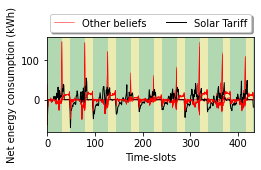

In [55]:
df_ = basic_plot(seed=101, update_q=True, tariff=False, start=130)

/home/guso/github/lemsim_code/venv/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
/home/guso/github/lemsim_code/venv/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


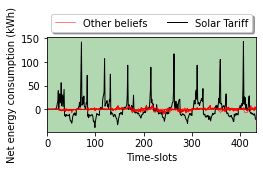

In [56]:
df_ = basic_plot(seed=101, update_q=True, tariff=True, start=130)

In [58]:
def pre_post_plot(seed, update_q, tariff, start, pt, freq):
    df_ = df[
        (df.seed == seed) & ((df.only_update_price == update_q) | (df.freq == 'None')) &
        (df.flat == tariff) & (df.start == start) & (df.pt == pt) & (df.freq == str(freq))
    ].copy()
    
    key = df_.index[0]
    dt = data[KEYS[key]][1]
    
    #def_key = df_[(df_.pt == 'pesimistic') & (df_.market == False)].index[0]
    #
    #defload = np.vstack([dt[n]['history_post_net'] for n in range(N)]).sum(axis=0)[: L - 47]
    prices_b = dt[0]['allprices'][:, 3]
    prices_s = dt[0]['allprices'][:, 0]
    
    pre_load = np.vstack([dt[n]['history_pre_net'] for n in range(N)]).sum(axis=0)[: L - 47]
    post_load = np.vstack([dt[n]['history_post_net'] for n in range(N)]).sum(axis=0)[: L - 47]
    
    #return df_
    
    fig = plt.figure(figsize=(14, 10), constrained_layout=True)
    ax = fig.add_subplot(111)
    
    for l in range(L - 47):
        color = 'y' if prices_b[l] > prices_b.min() else 'g'
        ax.axvspan(l, l+1, facecolor=color, alpha=0.3)
    

    ax.plot(pre_load, label='Desired Load', c='r')
    ax.plot(post_load, label='Consumed Load', c='b')
    
    ax.legend()
    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
    
    name = 'img/{}_{}_{}_{}_{}_{}_pre_post'.format(seed, update_q, tariff, start, pt, freq)
    

    
    ax.set_xlabel('Time-slots')
    ax.set_ylabel('Net energy consumption (kWh)')
    
    ax.set_xlim(0, L - 47)

    handles, labels = fig.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(.5, 1.3),
          ncol=2, fancybox=True, shadow=True)
    
    phi = (1 + np.sqrt(5)) * 0.5
    fig.set_size_inches(3.5, 3.5 / phi)
    fig.tight_layout(pad=0)
    fig.savefig(name + '.pgf')
    fig.show()
    
    return df_

/home/guso/github/lemsim_code/venv/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
/home/guso/github/lemsim_code/venv/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


,N,T,D,pt,market,freq,seed,only_update_price,flat,start,social_cost,increase_bottom_range,increase_top_range,local_matched
2,50,48,10,neutral,True,1,101,True,False,130,-1.409744,-39.03,99.14,-12.74


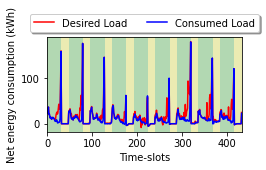

In [59]:
pre_post_plot(seed=101, update_q=True, tariff=False, start=130, pt='neutral', freq=1)

In [57]:
pre_post_plot(seed=101, update_q=True, tariff=False, start=130, pt='optimistic', freq=1)

NameError: name 'pre_post_plot' is not defined

In [22]:
df

,N,T,D,pt,market,freq,seed,only_update_price,flat,start,social_cost,increase_bottom_range,increase_top_range,local_matched
0,50,48,10,neutral,True,1,101,False,False,130,-1.447082,-47.13,92.55,2.74
1,50,48,10,neutral,True,1,101,False,True,130,-3.435842,-41.29,1.14,-1.34
2,50,48,10,neutral,True,1,101,True,False,130,-1.409744,-39.03,99.14,-12.74
3,50,48,10,neutral,True,1,101,True,True,130,-3.189985,-16.79,1.14,-15.29
4,50,48,10,neutral,True,1,1234,False,False,100,-1.386105,-72.82,136.99,7.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,50,48,10,unique,True,5,2210,True,True,120,4.261952,60.29,0.00,73.70
216,50,48,10,unique,True,5,3322,False,False,180,0.679681,12.11,-50.08,-4.12
217,50,48,10,unique,True,5,3322,False,True,180,-1.131731,-3.35,0.00,3.75
218,50,48,10,unique,True,5,3322,True,False,180,12.417847,59.42,-67.46,21.22


In [30]:
dt = data[KEYS[0]][1]
np.sum([dt[n]['history_cost'].sum() for n in range(N)])

97662.42083654413

In [32]:
dt2 = data[KEYS[get_default_key(0, df)]][1]
np.sum([dt2[n]['history_cost'].sum() for n in range(N)])

99096.44541109315

In [39]:
(97662.42083654413 - 99096.44541109315) / 99096.44541109315 * 100

-1.447099912211882

In [29]:
df.loc[80]

N                                50
T                                48
D                                10
pt                       pesimistic
market                        False
freq                           None
seed                            101
only_update_price             False
flat                          False
start                           130
social_cost                       0
increase_bottom_range             0
increase_top_range                0
local_matched                     0
Name: 80, dtype: object

In [42]:
increase_in_range(4, df)

New -4.64925115484586 185.69360529248823
Def -8.034699905735053 78.35465441540734


(-72.82, 136.99)